### **Задание №1**. Предположим, что у вас в базе есть табличка с балансом по всем счетам клиента на конец дня. Из-за особенностей построения таблицы, часть значений незаполнена и физически это означает отсутствие информации об изменении баланса. Для простоты будем считать, пропущенные значения для одного пользователя не могут встретиться между двумя заполненными. Напишите SQL запрос для заполнения неизвестных значений по каждому клиенту последним известным.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | NaN
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | NaN
3 | 18.04.2020 | NaN


In [ ]:
""" основаня таблица - sber

update sber
set value = last_values.last_value
from (
         select client_id,
                last_value(value) OVER (PARTITION BY client_id) as last_value
         from sber
         where value is not null
     ) as last_values
where sber.client_id = last_values.client_id
  and sber.value is null;
  
"""

### **Задание №1.1 (*)**. В прошлом задании мы считали, что пропущенные значения не могут находиться между двумя заполненными в рамках одного пользователя, что не всегда правда в реальных задачах. Напишите теперь SQL запрос без указанного допущения.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | 7000
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | 49000
3 | 18.04.2020 | NaN

In [ ]:
""" основаня таблица - sber2

update sber2
set value = desired_values.desired_value
from (select client_id,
             date,
             value,
             first_value(value) over (partition by group_number) as desired_value
      from (select client_id,
                   date,
                   value,
                   sum(case when value is not null then 1 end) over (order by client_id, date) as group_number
            from sber2
           ) as groups
     ) as desired_values
where sber2.client_id = desired_values.client_id
  and sber2.date = desired_values.date
  and sber2.value is null;
  
"""

### **Задание №2**. Пусть клиенты обладают рядом статусов, закодированных цифрами: 0 - "улица", 1 - "зарплатник", 2 - "премиум", 3 - "пенсионер", 4 - "студент". У нас есть матрица с логами смен статусов за некоторый период, разверните ее в матрицу статус - статус с частотами перехода между ними.

Пример, как было:

client_id | prev_segment | new_segment|
--- | --- | ---
1 | 0 | 1
2 | 0 | 2
3 | 4 | 3

Пример, как нужно:

segment |0 | 1 | 2 | 3 | 4 
--- | --- | --- | --- | --- | ---
0 | 0 | 0.5 | 0.5 | 0 | 0 
1 | 0 |0 | 0 | 0 | 0
2 | 0 | 0 | 0 | 0 | 0
3 | 0 | 0 | 0 | 0 | 0
4 | 0 | 0 | 0 | 1 | 0

В процессе выполнения задания разрешается пользоваться библиотеками numpy и pandas.

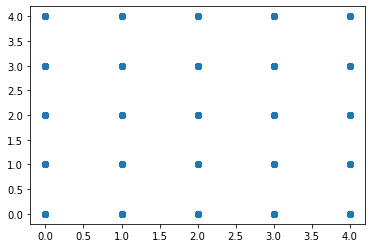

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Сгенерируем данные для задачи
data = pd.DataFrame(
    np.random.randint(low=0, high=5, size=(500000, 2)),
    columns=['prev_segment', 'new_segment']
)
plt.scatter(data['prev_segment'], data['new_segment'])

In [2]:
temp = np.zeros((len(pd.unique(data['prev_segment'])), 
                 len(pd.unique(data['new_segment']))))

for col in range(0, len(data)):
    x = data.at[col, 'prev_segment']
    y = data.at[col, 'new_segment']
    temp[x][y]+=1

result = temp/temp.sum(axis=1, keepdims=True)
pd.DataFrame(result) # главная диагональ результирующей матрицы отражает отсутствие переходов между статусами

,0,1,2,3,4
0,0.200446,0.200916,0.199896,0.197795,0.200946
1,0.201334,0.197894,0.200401,0.198365,0.202006
2,0.199982,0.199163,0.199013,0.199243,0.202599
3,0.197967,0.200261,0.199812,0.200980,0.200980
4,0.199290,0.199880,0.200680,0.199920,0.200230


### **Задание №2.1 (*)**. Если вы не пользовались библиотечными функциями и реализовывали алгоритм самостоятельно, напишите, пожалуйста, его асимптотическую сложность в терминах O-большое.

Асимптотическая сложность равна O(n), так как алгоритм перебиает все элементы массива.

### **Задание №3**. Постройте прогнозую модель для датасета с UCI Machine Learning: предобработайте категориальные фичи, отберите их, соберите схему валидации и отберите модели с помощью нее. Описание датасета по ссылке: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Данная задача multilabel multiclass classification, поэтому предлагаю начать с одного из подходов:
- Свести задачу к multilabel binary classification, как это указано в описании к датасету;
- Свести задачку к binary classification тем или иным способом;
- Обучить множество multiclass/binary classification моделей;
- Что-то еще, что придет в голову.


In [3]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data'

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier

In [5]:
data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [6]:
data.columns = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore',
                'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol', 'Amphet', 'Amyl',
                'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin',
                'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']
data.index.rename('Id', inplace=True)
data.reset_index(inplace=True)

In [7]:
data.head(1)

,Id,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0


In [8]:
data.isna().sum()

Id           0
Age          0
Gender       0
Education    0
Country      0
Ethnicity    0
Nscore       0
Escore       0
Oscore       0
Ascore       0
Cscore       0
Impulsive    0
SS           0
Alcohol      0
Amphet       0
Amyl         0
Benzos       0
Caff         0
Cannabis     0
Choc         0
Coke         0
Crack        0
Ecstasy      0
Heroin       0
Ketamine     0
Legalh       0
LSD          0
Meth         0
Mushrooms    0
Nicotine     0
Semer        0
VSA          0
dtype: int64

In [9]:
uni_1 = data.nunique()
uni_1

Id           1885
Age             6
Gender          2
Education       9
Country         7
Ethnicity       7
Nscore         49
Escore         42
Oscore         35
Ascore         41
Cscore         41
Impulsive      10
SS             11
Alcohol         7
Amphet          7
Amyl            7
Benzos          7
Caff            7
Cannabis        7
Choc            7
Coke            7
Crack           7
Ecstasy         7
Heroin          7
Ketamine        7
Legalh          7
LSD             7
Meth            7
Mushrooms       7
Nicotine        7
Semer           5
VSA             7
dtype: int64

In [10]:
data.describe()

,Id,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
count,1885.000000,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [11]:
def toFixed(x):
    x = float('{:.5f}'.format(x)) # укажем точные значения float до 5го знака
    return x

for i in list(data.columns[1:6]): # для 2-6 столбцов
    data[i] = data[i].map(toFixed)

In [12]:
"""Декодируем данные из 2-6 столбцов в соответствии с ключами, указанными в описании к датасету. """

keys_list = [{-0.95197:0, -0.07854:1, 0.49788:2, 1.09449:3, 1.82213:4, 2.59171:5},
             {0.48246:0, -0.48246:1}, 
             {-2.43591:0, -1.73790:1, -1.43719:2, -1.22751:3, -0.61113:4, -0.05921:5, 0.45468:6, 1.16365:7, 1.98437:8},
             {-0.09765:0, 0.24923:1, -0.46841:2, -0.28519:3, 0.21128:4, 0.96082:5, -0.57009:6},
             {-0.50212:0, -1.10702:1, 1.90725:2, 0.12600:3, -0.22166:4, 0.11440:5, -0.31685:6}]

data = data.assign(Age=data.Age.map(keys_list[0]))
data = data.assign(Gender=data.Gender.map(keys_list[1]))
data = data.assign(Education=data.Education.map(keys_list[2]))
data = data.assign(Country=data.Country.map(keys_list[3]))
data = data.assign(Ethnicity=data.Ethnicity.map(keys_list[4]))

In [13]:
data[data.isna().any(axis=1)]

,Id,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA


In [14]:
def change(a): # переведем 7 классов времени в бинарный вид
    if ((a == 'CL6') or (a == 'CL5') or (a == 'CL4') ): # будем считать фактом приема наркотиков в течение месяца
        a = 1
    elif ((a == 'CL0') or (a == 'CL1') or (a == 'CL2') or (a == 'CL3')):
        a = 0
    return a

In [15]:
for name in data.columns[13:32]:
    data[name] = data[name].map(change)
    
data.iloc[0:, 13:32]

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1881,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,1,0,0
1882,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0
1883,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0


In [16]:
"""Объединим наркотики в три группы в соовтетсвии с описанием датасета 
и выкинем всё лишнее, включая легальные наркотики."""

data['heroinPl'] = data.apply(lambda x: int((x['Coke'] + x['Crack'] + x['Heroin'] + 
                                             x['Meth'])>0), axis = 1)
data['ecstasyPl'] = data.apply(lambda x: int((x['Amphet']  + x['Cannabis'] + x['Coke']  + 
                                              x['Ecstasy'] + x['Ketamine'] + x['LSD'] + 
                                              x['Meth'] + x['Mushrooms'] )>0), axis = 1)
data['benzoPl'] = data.apply(lambda x: int((x['Amphet'] + x['Coke'] + x['Meth'])>0), axis = 1)
data.drop(['Caff', 'Choc' ,'Nicotine', 'Legalh', 'Alcohol', 'Amphet',
           'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy',
           'Heroin', 'Ketamine', 'LSD', 'Meth', 'Mushrooms', 'Semer', 'VSA'], axis = 1, inplace = True)

In [17]:
data

,Id,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,heroinPl,ecstasyPl,benzoPl
0,1,2,0,5,5,3,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0,0,0
1,2,1,1,8,5,6,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,0,1,0
2,3,2,1,5,5,6,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,0,0,0
3,4,0,0,7,5,6,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,0,0,0
4,5,2,0,8,5,6,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,0,0,4,6,6,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,0,1,0
1881,1885,0,1,4,6,6,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,1,1,1
1882,1886,1,0,6,6,6,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,1,1,1
1883,1887,0,0,4,6,6,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,0,1,0


D:\anaconda\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\anaconda\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


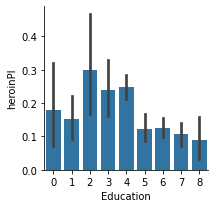

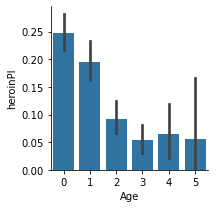

In [18]:
def plot_categories(data, cat, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(data, row=row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()
    
plot_categories(data, cat = 'Education' , target = 'heroinPl')
plot_categories(data, cat = 'Age' , target = 'heroinPl')

D:\anaconda\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\anaconda\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


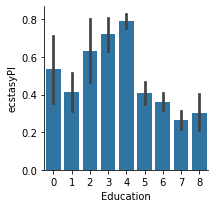

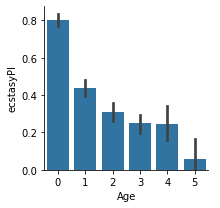

In [19]:
plot_categories(data, cat = 'Education' , target = 'ecstasyPl')
plot_categories(data, cat = 'Age' , target = 'ecstasyPl')

D:\anaconda\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\anaconda\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


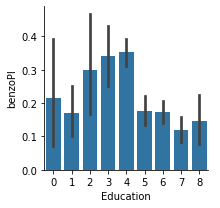

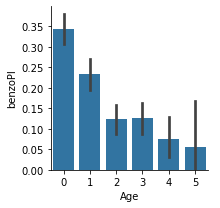

In [20]:
plot_categories(data, cat = 'Education' , target = 'benzoPl')
plot_categories(data, cat = 'Age' , target = 'benzoPl')

In [21]:
print(uni_1[:14]) # проверяем до и после обработки данных
print(data.nunique())

Id           1885
Age             6
Gender          2
Education       9
Country         7
Ethnicity       7
Nscore         49
Escore         42
Oscore         35
Ascore         41
Cscore         41
Impulsive      10
SS             11
Alcohol         7
dtype: int64
Id           1885
Age             6
Gender          2
Education       9
Country         7
Ethnicity       7
Nscore         49
Escore         42
Oscore         35
Ascore         41
Cscore         41
Impulsive      10
SS             11
heroinPl        2
ecstasyPl       2
benzoPl         2
dtype: int64


In [22]:
"""Построим матрицы корреляций."""

def plot_correlation_map(data):
    corr = data.corr()
    _,ax = plt.subplots(figsize=(10, 8))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    _=sns.heatmap(corr,
                  cmap = cmap,
                  square=True,
                  cbar_kws={'shrink':.9},
                  annot = True,
                  annot_kws = {'fontsize':8})

data1 = data.drop(['ecstasyPl', 'benzoPl'], axis=1)
data2 = data.drop(['heroinPl', 'benzoPl'], axis=1)
data3 = data.drop(['heroinPl', 'ecstasyPl'], axis=1)

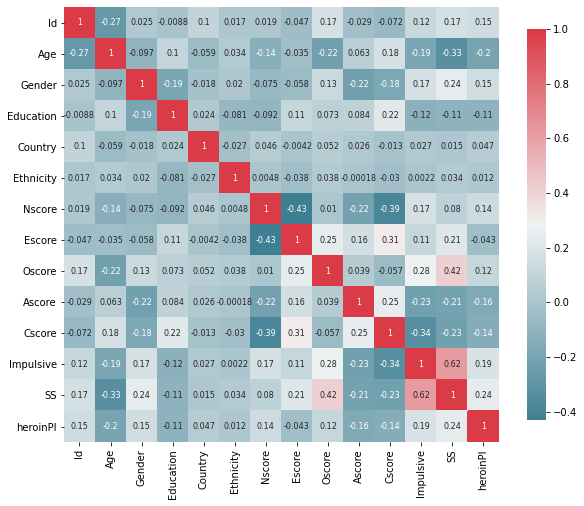

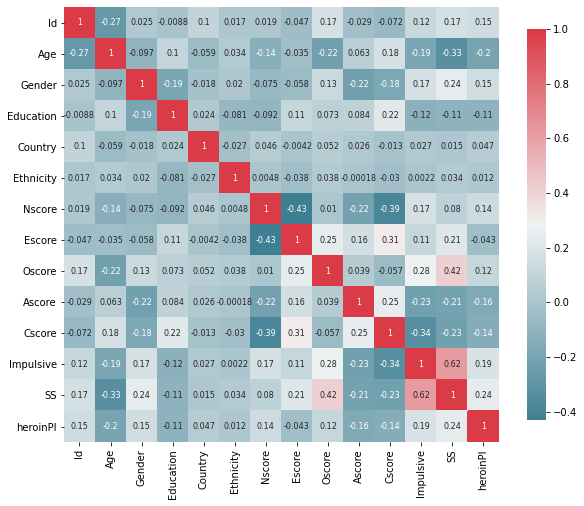

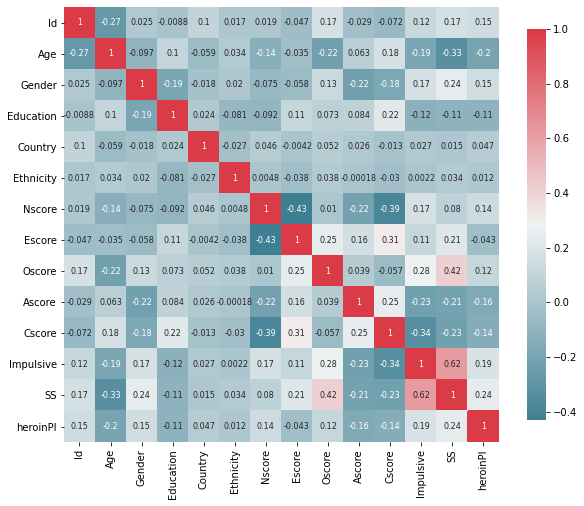

In [23]:
for i in (data1, data2, data3):
    plot_correlation_map(data1)

In [24]:
"""Удалим лишние данные."""

data1 = data1.drop(['Ethnicity', 'Country'], axis=1)
data2 = data2.drop(['Ethnicity', 'Country'], axis=1)
data3 = data3.drop(['Ethnicity', 'Country'], axis=1)

In [25]:
"""Проверим сбалансированность данных."""

print('heroinPl-:', float('{:.3f}'.format(1 - data1.heroinPl.sum()/len(data)))*100, '%')
print('heroinPl+:', float('{:.3f}'.format(data1.heroinPl.sum()/len(data)))*100, '%')
print('ecstasyPl-:', float('{:.3f}'.format(1 - data2.ecstasyPl.sum()/len(data)))*100, '%')
print('ecstasyPl+:', float('{:.3f}'.format(data2.ecstasyPl.sum()/len(data)))*100, '%')
print('benzoPl-:', float('{:.3f}'.format(1 - data3.benzoPl.sum()/len(data)))*100, '%')
print('benzoPl+:', float('{:.3f}'.format(data3.benzoPl.sum()/len(data)))*100, '%')

heroinPl-: 83.6 %
heroinPl+: 16.400000000000002 %
ecstasyPl-: 50.5 %
ecstasyPl+: 49.5 %
benzoPl-: 77.60000000000001 %
benzoPl+: 22.400000000000002 %


In [26]:
"""Применим One-hot encoding к Education и Age по всему датасету."""

dummies_education = pd.get_dummies(data1['Education'], prefix = 'Education')
data1 = pd.concat([data1, dummies_education], axis = 1)
dummies_age = pd.get_dummies(data1['Age'], prefix = 'Age')
data1 = pd.concat([data1, dummies_age], axis = 1)

dummies_education = pd.get_dummies(data2['Education'], prefix = 'Education')
data2 = pd.concat([data2, dummies_education], axis = 1)
dummies_age = pd.get_dummies(data2['Age'], prefix = 'Age')
data2 = pd.concat([data2, dummies_age], axis = 1)

dummies_education = pd.get_dummies(data3['Education'], prefix = 'Education')
data3 = pd.concat([data3, dummies_education], axis = 1)
dummies_age = pd.get_dummies(data3['Age'], prefix = 'Age')
data3 = pd.concat([data3, dummies_age], axis = 1)

In [27]:
data1 = data1.drop(['Education', 'Age'], axis=1)
data2 = data2.drop(['Education', 'Age'], axis=1)
data3 = data3.drop(['Education', 'Age'], axis=1)

In [28]:
"""Поместим целевой признак в отдельную переменную."""

y1 = data1['heroinPl']
X1 = data1.drop(['heroinPl'], axis=1)

y2 = data2['ecstasyPl']
X2 = data2.drop(['ecstasyPl'], axis=1)

y3 = data3['benzoPl']
X3 = data3.drop(['benzoPl'], axis=1)

In [29]:
"""Разделим датасеты на train и test с параметром stratify по несбалансированным данным."""

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 69, stratify=y1)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 69)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state = 69, stratify=y3)

In [41]:
"""Посмотрим на важность признаков на основе нашего разбиения."""

def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(model.feature_importances_,
                       columns = ['Importance'],
                       index = X.columns)
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[:10].plot(kind='barh')
    print(model.score(X, y))

def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=69)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)

1.0


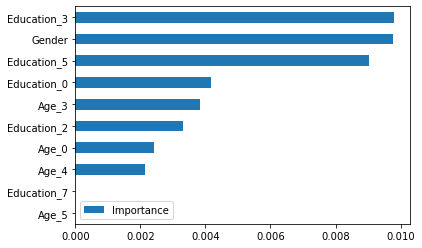

In [42]:
plot_variable_importance(X1_train, y1_train)

1.0


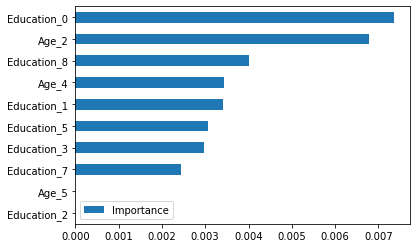

In [43]:
plot_variable_importance(X2_train, y2_train)

1.0


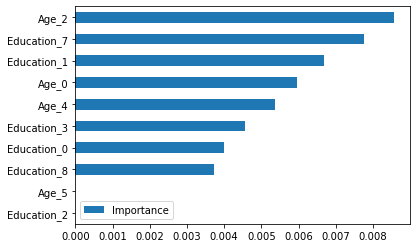

In [44]:
plot_variable_importance(X3_train, y3_train)

In [45]:
"""Кросс-валидация и случайный лес."""

model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
scores1 = cross_validate(model, X1_train, y1_train, cv=3, scoring=('accuracy'), return_train_score=True)
scores2 = cross_validate(model, X2_train, y2_train, cv=3, scoring=('accuracy'), return_train_score=True)
scores3 = cross_validate(model, X3_train, y3_train, cv=3, scoring=('accuracy'), return_train_score=True)

In [46]:
print(np.mean(scores1['test_score']))
print(np.mean(scores2['test_score']))
print(np.mean(scores3['test_score']))

0.8355405416108924
0.8010661132804765
0.7904459035956902


In [47]:
"""KNN."""

parameters = {'n_neighbors':[3, 5, 10, 15]}
model_cv = GridSearchCV(KNeighborsClassifier(), parameters, cv=3, scoring=('accuracy'),
                        return_train_score=True)
model_cv.fit(X1_train, y1_train)
best_model = KNeighborsClassifier(n_neighbors=4)
best_model.fit(X1_train, y1_train)
accuracy_score(best_model.predict(X1_test), y1_test)

0.8196286472148541

In [48]:
model_cv.fit(X2_train, y2_train)
best_model = KNeighborsClassifier(n_neighbors=7)
best_model.fit(X2_train, y2_train)
accuracy_score(best_model.predict(X2_test), y2_test)

0.8010610079575596

In [49]:
model_cv.fit(X3_train, y3_train)
best_model = KNeighborsClassifier(n_neighbors=8)
best_model.fit(X3_train, y3_train)
accuracy_score(best_model.predict(X3_test), y3_test)

0.7851458885941645

In [50]:
"""Пробуем логистическую регрессию."""

parameters = {'penalty':['l1', 'l2']}
model_cv = GridSearchCV(LogisticRegression(), parameters, 
                        cv=3, scoring=('accuracy'), return_train_score=True)
model_cv.fit(X1_train, y1_train)
model_cv.cv_results_

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status

{'mean_fit_time': array([0.0004096 , 0.02278479]),
 'std_fit_time': array([0.00042661, 0.00144463]),
 'mean_score_time': array([0.        , 0.00098801]),
 'std_score_time': array([0.00000000e+00, 1.31498167e-05]),
 'param_penalty': masked_array(data=['l1', 'l2'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'penalty': 'l1'}, {'penalty': 'l2'}],
 'split0_test_score': array([       nan, 0.84691849]),
 'split1_test_score': array([       nan, 0.83697813]),
 'split2_test_score': array([       nan, 0.83266932]),
 'mean_test_score': array([       nan, 0.83885531]),
 'std_test_score': array([       nan, 0.00596672]),
 'rank_test_score': array([2, 1]),
 'split0_train_score': array([       nan, 0.83781095]),
 'split1_train_score': array([     nan, 0.839801]),
 'split2_train_score': array([       nan, 0.83797217]),
 'mean_train_score': array([       nan, 0.83852804]),
 'std_train_score': array([       nan, 0.00090252])}

In [51]:
best_model = LogisticRegression(penalty = 'l1', solver='liblinear')
best_model.fit(X1_train, y1_train)
accuracy_score(best_model.predict(X1_test), y1_test)

0.830238726790451

In [52]:
best_model = LogisticRegression(penalty = 'l2')
best_model.fit(X2_train, y2_train)
accuracy_score(best_model.predict(X1_test), y1_test)

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6259946949602122

In [53]:
best_model = LogisticRegression(penalty = 'l2')
best_model.fit(X3_train, y3_train)
accuracy_score(best_model.predict(X1_test), y1_test)

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8381962864721485

In [54]:
"""EcstasyPl отдельно."""

log_reg = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver = 'liblinear', 
                                                             class_weight='balanced'))
scv = KFold(n_splits=5)
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['CV'])

for metric in metric_names:
    scores = cross_val_score(log_reg, X2_train, y2_train, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [scores]
scores_df

,CV
f1,0.786
roc_auc,0.876262
average_precision,0.878933
accuracy,0.79244
precision,0.807869
recall,0.765558


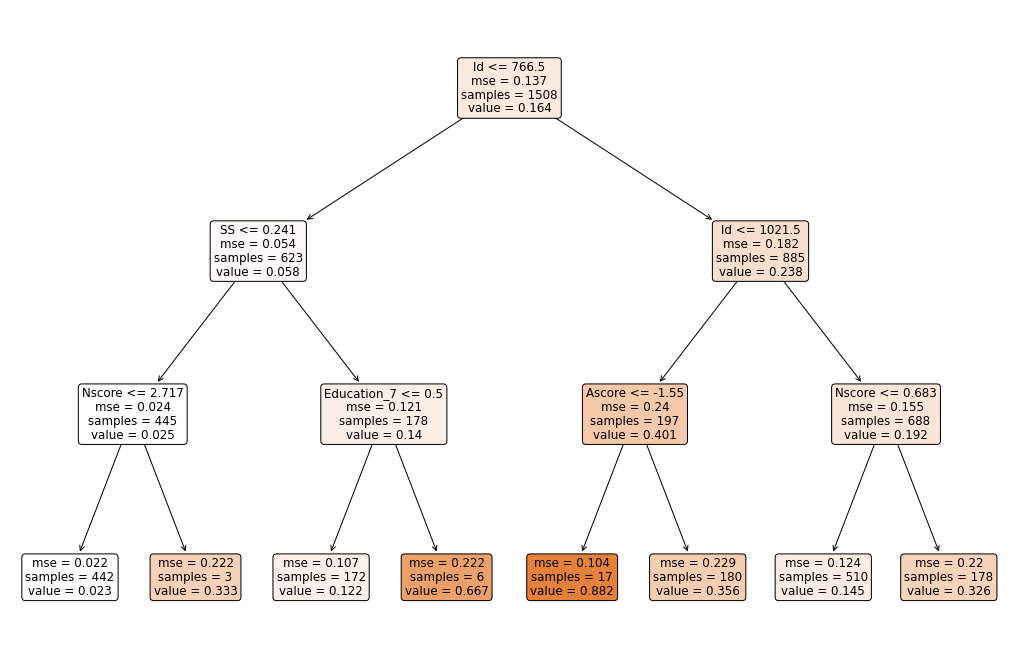

In [55]:
"""Попробуем Решающее дерево, например."""

tree = DecisionTreeRegressor(max_depth=3, random_state=69).fit(X1_train, y1_train)
plt.figure(figsize=(18,12))
plot_tree(tree, feature_names=data1.columns, filled=True, rounded=True)
plt.show()

In [56]:
mean_squared_error(y1_test, tree.predict(X1_test))

0.13895797332563198

In [57]:
"""Наивный Байес, например."""

clf = GaussianNB()
clf.fit(X1_train, y1_train)
accuracy_score(clf.predict(X1_test), y1_test)

0.6949602122015915

In [58]:
clf.fit(X2_train, y2_train)
accuracy_score(clf.predict(X2_test), y2_test)

0.7374005305039788

In [59]:
clf.fit(X1_train, y1_train)
accuracy_score(clf.predict(X3_test), y3_test)

0.6816976127320955

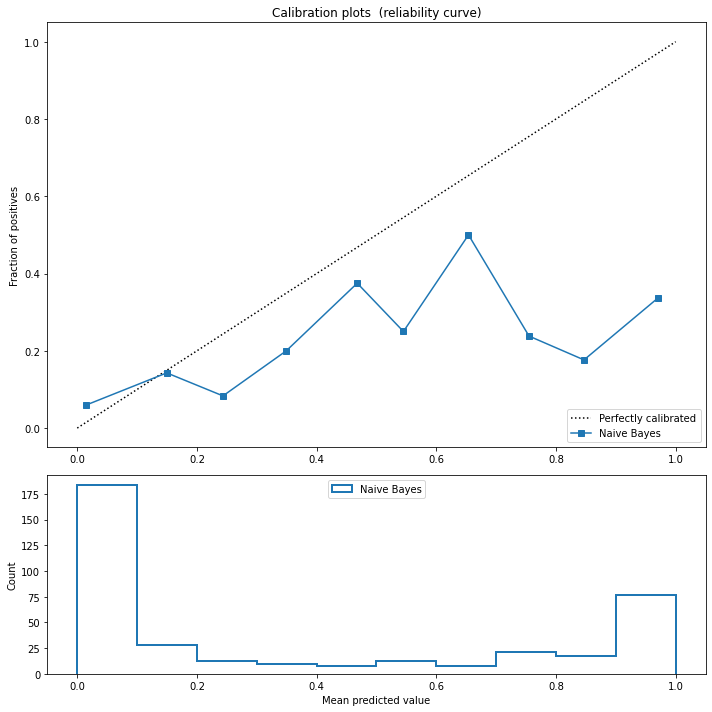

In [60]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
gnb = GaussianNB()

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

gnb.fit(X1_train, y1_train)
if hasattr(gnb, "predict_proba"):
    prob_pos = gnb.predict_proba(X1_test)[:, 1]
else:
    prob_pos = gnb.decision_function(X1_test)
    prob_pos = \
        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
fraction_of_positives, mean_predicted_value = \
    calibration_curve(y1_test, prob_pos, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s" % ('Naive Bayes', ))

ax2.hist(prob_pos, range=(0, 1), bins=10, label='Naive Bayes',
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

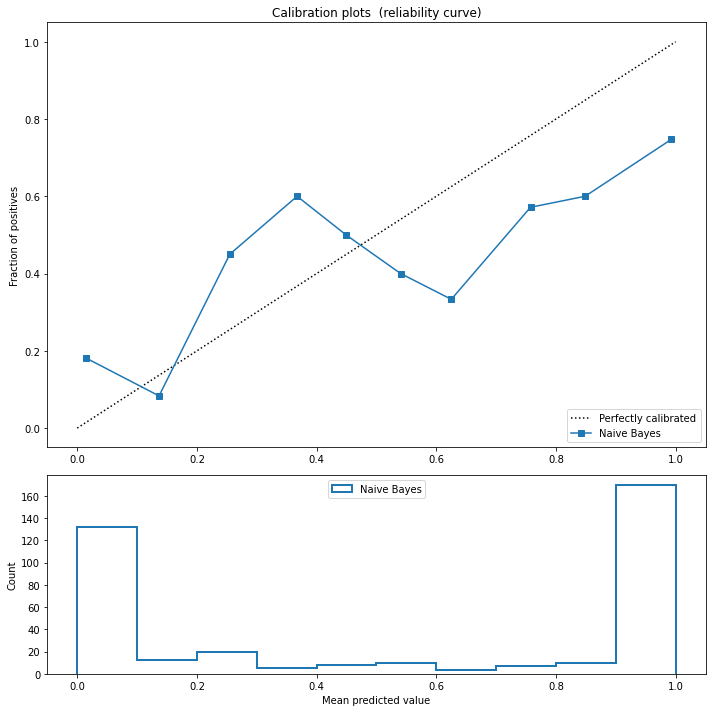

In [61]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
gnb = GaussianNB()

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

gnb.fit(X2_train, y2_train)
if hasattr(gnb, "predict_proba"):
    prob_pos = gnb.predict_proba(X2_test)[:, 1]
else:
    prob_pos = gnb.decision_function(X2_test)
    prob_pos = \
        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
fraction_of_positives, mean_predicted_value = \
    calibration_curve(y2_test, prob_pos, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s" % ('Naive Bayes', ))

ax2.hist(prob_pos, range=(0, 1), bins=10, label='Naive Bayes',
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

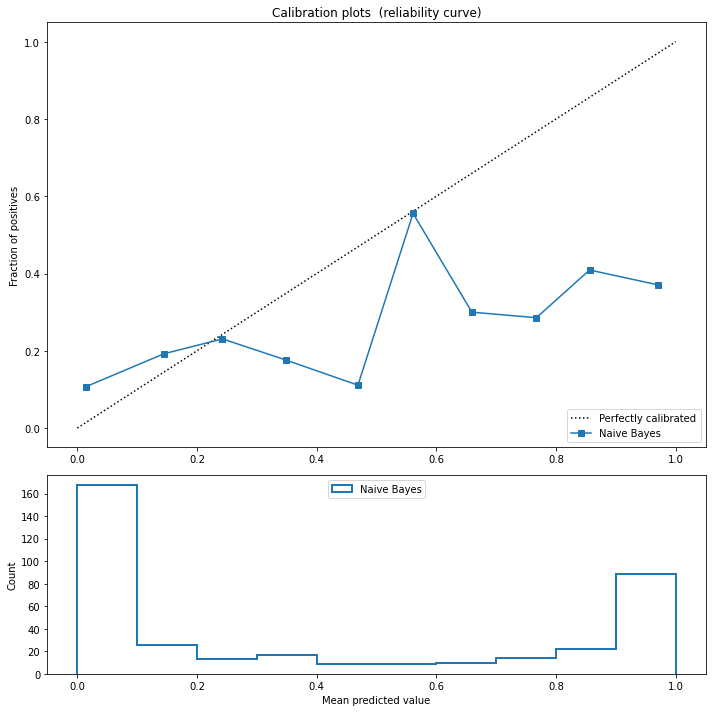

In [62]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
gnb = GaussianNB()

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

gnb.fit(X1_train, y1_train)
if hasattr(gnb, "predict_proba"):
    prob_pos = gnb.predict_proba(X3_test)[:, 1]
else:
    prob_pos = gnb.decision_function(X3_test)
    prob_pos = \
        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
fraction_of_positives, mean_predicted_value = \
    calibration_curve(y3_test, prob_pos, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s" % ('Naive Bayes', ))

ax2.hist(prob_pos, range=(0, 1), bins=10, label='Naive Bayes',
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

### **Задание №4**. Предположим, что мы построили рекомендательную систему, и ожидаем, что средний чек клиента вследствие этого должен вырасти. Мы провели AB-тест и собрали данные по контрольной и тестовой группе. Предложите и проведите статистический тест, который можно применить к этим данным.

В процессе выполнения задания разрешено пользоваться библиотеками scipy и statsmodels.

In [63]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.gofplots import qqplot
from tqdm import tnrange, tqdm

# Сгенерируем данные для задачи
control = np.random.lognormal(mean=5, sigma=2, size=(100000,))
test = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

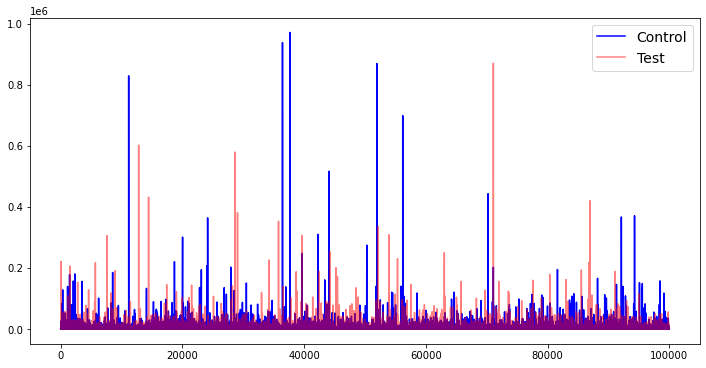

In [64]:
plt.figure(figsize=(12,6))
plt.plot(control, color='blue', label='Control')
plt.plot(test, color='red', alpha=0.5, label='Test')
plt.legend(fontsize=14)
plt.show()

In [65]:
print('Изменение среднего:', (np.mean(test)-(np.mean(control)))/(np.mean(control)+np.mean(test))*100, '%')
print('Изменение медианы:', (np.median(test)-np.median(control))/(np.median(control)+np.median(test))*100, '%')

Изменение среднего: 1.6751405364428924 %
Изменение медианы: 1.7105909427399695 %


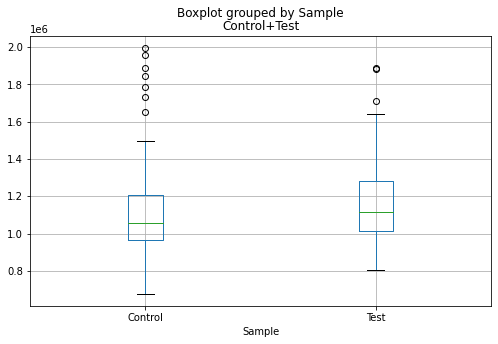

In [66]:
"""Используем boxplot для наглядности на устредненных данных."""

df = pd.DataFrame(control, columns=['Control+Test'])
df = df.groupby(np.arange(len(df))//1000).sum()
df['Sample']='Control'

df2 = pd.DataFrame(test, columns=['Control+Test'])
df2 = df2.groupby(np.arange(len(df2))//1000).sum()
df2['Sample']='Test'

df3 = df.append(df2)

df3.boxplot(column='Control+Test', by='Sample',figsize=(8,5))
plt.show()

In [67]:
"""Медиана попарных разностей, проверим насколько средний чек в выборке control 
отличается от среднего чека в выборке test.
"""

df = pd.DataFrame(control)
df = df.groupby(np.arange(len(df))//25).mean().to_numpy()

df2 = pd.DataFrame(test)
df2 = df2.groupby(np.arange(len(df2))//25).mean().to_numpy()

np.median([[ df[i] - df2[j] for j in range(len(df2))] for i in tnrange(len(df))])

<ipython-input-67-1ae3e42a4319>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  np.median([[ df[i] - df2[j] for j in range(len(df2))] for i in tnrange(len(df))])


-40.69145652488791

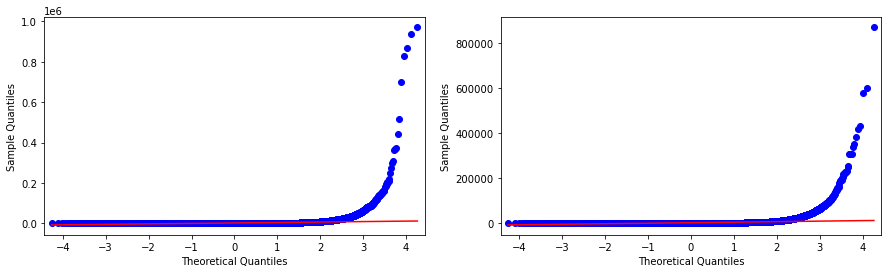

In [69]:
"""Проверяем на нормальность."""

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4)) 
qqplot(control, line='r', ax=ax1)
qqplot(test, line='r', ax=ax2)
plt.show()

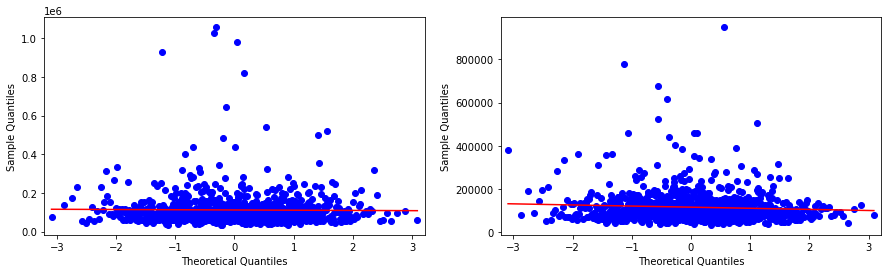

In [70]:
"""Применим бакетное преобразование."""

df = pd.DataFrame(control, columns=['Control+Test'])
df = df.groupby(np.arange(len(df))//100).sum()
df2 = pd.DataFrame(test, columns=['Control+Test'])
df2 = df2.groupby(np.arange(len(df2))//100).sum()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4)) 
qqplot(df, line='r', ax=ax1)
qqplot(df2, line='r', ax=ax2)
plt.show()

In [71]:
"""Посчитаем доверительный интервал на основе параметрического бутстрэпа для выборки test."""

number_of_bootstrap_samples = 100
size_of_bootstrap_samples = 100

bootstrap_samples = np.random.normal(np.mean(test),2,size=[number_of_bootstrap_samples,
                                                           size_of_bootstrap_samples])
bootstrap_estimates = np.apply_along_axis(np.mean, 1, bootstrap_samples)
[np.quantile(bootstrap_estimates,0.05/2), np.quantile(bootstrap_estimates,
                                                                             1-0.05/2)]

[1158.5476210497716, 1159.3449510809508]

In [72]:
"""Критерий Колмогорова-Смирнова, проверяем гипотезу о равенстве двух функций распределений, 
из которых получены выборки, против гипотезы о том, что вторая выборка стохастически принимает 
большие значения.
"""

print(stats.ks_2samp(control, test))
print(stats.ks_2samp(control, test, alternative='less'))

KstestResult(statistic=0.00927, pvalue=0.000368360349548018)
KstestResult(statistic=0.0002400000000000002, pvalue=0.9940179640539353)


In [73]:
"""Критерий Манна-Уитни, проверяем гипотезу о равенстве двух функций распределений, 
из которых получены выборки, против альтернативы доминирования.
"""

print(stats.mannwhitneyu(control, test))
print(stats.mannwhitneyu(control, test, alternative='greater'))

MannwhitneyuResult(statistic=4944028370.0, pvalue=7.270369857512658e-06)
MannwhitneyuResult(statistic=4944028370.0, pvalue=0.9999927296327028)


In [74]:
"""Критерий Стьюдента, проверяем гипотезу о равенстве средних двух выборок 
против любой альтернативы.
"""

stats.ttest_ind(control, test)

Ttest_indResult(statistic=-1.0760206762467426, pvalue=0.2819193074317059)

### **Задание №4 (*)**. В прошлом задании мы улавливали статистически значимое различие в средних в 0.04 единицы на выборке из 100000 клиентов. Насколько больше нам требуется собрать клиентов, чтобы уловить различие в 0.02?

N=1,96^2*41.65/0.0004

N=400000